In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import string
import re
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\16920\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\16920\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\16920\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
raw_df = pd.read_csv('train-balanced-sarcasm.csv')
raw_df.isnull().sum()
raw_df.dropna(inplace=True)
raw_df.head()

label                                            comment     author  \
0      0                                         NC and NH.  Trumpbart   
1      0  You do know west teams play against west teams...  Shbshb906   
2      0  They were underdogs earlier today, but since G...   Creepeth   
3      0  This meme isn't funny none of the "new york ni...  icebrotha   
4      0                    I could use one of those tools.  cush2push   

            subreddit  score  ups  downs     date          created_utc  \
0            politics      2   -1     -1  2016-10  2016-10-16 23:55:23   
1                 nba     -4   -1     -1  2016-11  2016-11-01 00:24:10   
2                 nfl      3    3      0  2016-09  2016-09-22 21:45:37   
3  BlackPeopleTwitter     -8   -1     -1  2016-10  2016-10-18 21:03:47   
4  MaddenUltimateTeam      6   -1     -1  2016-12  2016-12-30 17:00:13   

                                      parent_comment  
0  Yeah, I get that argument. At this point, I'd ...  
1  The blazers and Mavericks (The wests 5 and 6 s...  
2                            They're favored to win.  
3                         deadass don't kill my buzz  
4  Yep can confirm I saw the tool they use for th...

In [3]:
# Convert 'created_utc' to datetime to extract the year
raw_df['created_utc'] = pd.to_datetime(raw_df['created_utc'])
raw_df['year'] = raw_df['created_utc'].dt.year

Target_Year = 2015

# filter out the sarcastic comments
sarcastic_comments = raw_df[raw_df['label'] == 1]
sarcastic_comments_year = sarcastic_comments[sarcastic_comments['year'] == Target_Year]

# filter out the non-sarcastic comments
n_sarcastic_comments = raw_df[raw_df['label'] == 0]

# Topic Modelling

In [4]:
# Function to preprocess text and return words as a comma-separated string
def preprocess_text(text):
    # Step 1: Convert text to lowercase
    text = text.lower()
    # Step 2: Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Step 3: Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Step 4: Remove stopwords (common words like "the," "is," etc.)
    text = " ".join([word for word in nltk.word_tokenize(text) if word.lower() not in stopwords.words('english')])
    # Step 5: Remove short words (length < 3)
    text = " ".join([word for word in nltk.word_tokenize(text) if len(word) >= 3])
    return text

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    # Lemmatize each word in the text
    text = " ".join([lemmatizer.lemmatize(word) for word in nltk.word_tokenize(text)])
    return text

In [5]:
sarcastic_processed = []


for text in tqdm(sarcastic_comments_year["comment"]):
    # Step 6: Preprocess the text
    preprocessed_text = preprocess_text(text)
    # Step 7: Lemmatize the preprocessed text
    preprocessed_text = lemmatize_text(preprocessed_text)
    # Append the processed text to the list
    sarcastic_processed.append(preprocessed_text)


100%|██████████| 149297/149297 [04:00<00:00, 621.28it/s]


In [6]:
sarcastic_processed[:10]

['war christmas duh',
 'dont love smell boiling frog',
 'papa roach scar running head thank',
 'omg bill superbowl',
 'yeah line sight internet sound great',
 'maybe guy hamiltonian functionoperator named lewis hamilton pilot',
 'delete',
 'omitted',
 'didnt shoot domestic partner though completely',
 'thats clearly sys admin job']

In [7]:
# vectorize the parent_comment and comment columns
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2))
vec = vectorizer.fit_transform(sarcastic_processed)

In [8]:
from sklearn.decomposition import LatentDirichletAllocation
num_topics = 8
lda_model = LatentDirichletAllocation(n_components=num_topics, learning_method='online', random_state=42, max_iter=1)

In [9]:
lda_top = lda_model.fit_transform(vec)

In [11]:
print(lda_model.components_)

[[ 0.12500116  0.12500116  0.12508091 ...  0.12500219  0.12500219
   0.12500087]
 [ 0.13925846  0.13925846  0.12515006 ...  0.1250028   0.1250028
   0.12821122]
 [ 0.1250013   0.1250013   0.12503039 ...  0.13840689  0.13840689
   0.12500096]
 ...
 [ 0.12500148  0.12500148  0.12566086 ...  0.1250028   0.1250028
   0.1250011 ]
 [ 0.12500127  0.12500127 10.29285159 ...  0.12500241  0.12500241
   0.12500094]
 [ 0.12500133  0.12500133  0.13393919 ...  0.1250025   0.1250025
   0.12500097]]


In [12]:
vocab = vectorizer.get_feature_names_out()

for i, comp in enumerate(lda_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
black need people better much make obviously youre would way 
Topic 1: 
got rape yay quality called least vote fucking drug course 

Topic 2: 
look sorry definitely thanks nice bad see like feel fun 
Topic 3: 
yeah get totally yes thing fuck right one people good 
Topic 4: 
dont like know sound wow lol men new never dont know 
Topic 5: 
funny must post really joke true love video guess good 
Topic 6: 
white people whats gay girl hope trying poor work run 

Topic 7: 
forgot sure dropped think thats racist idea year ever nah 


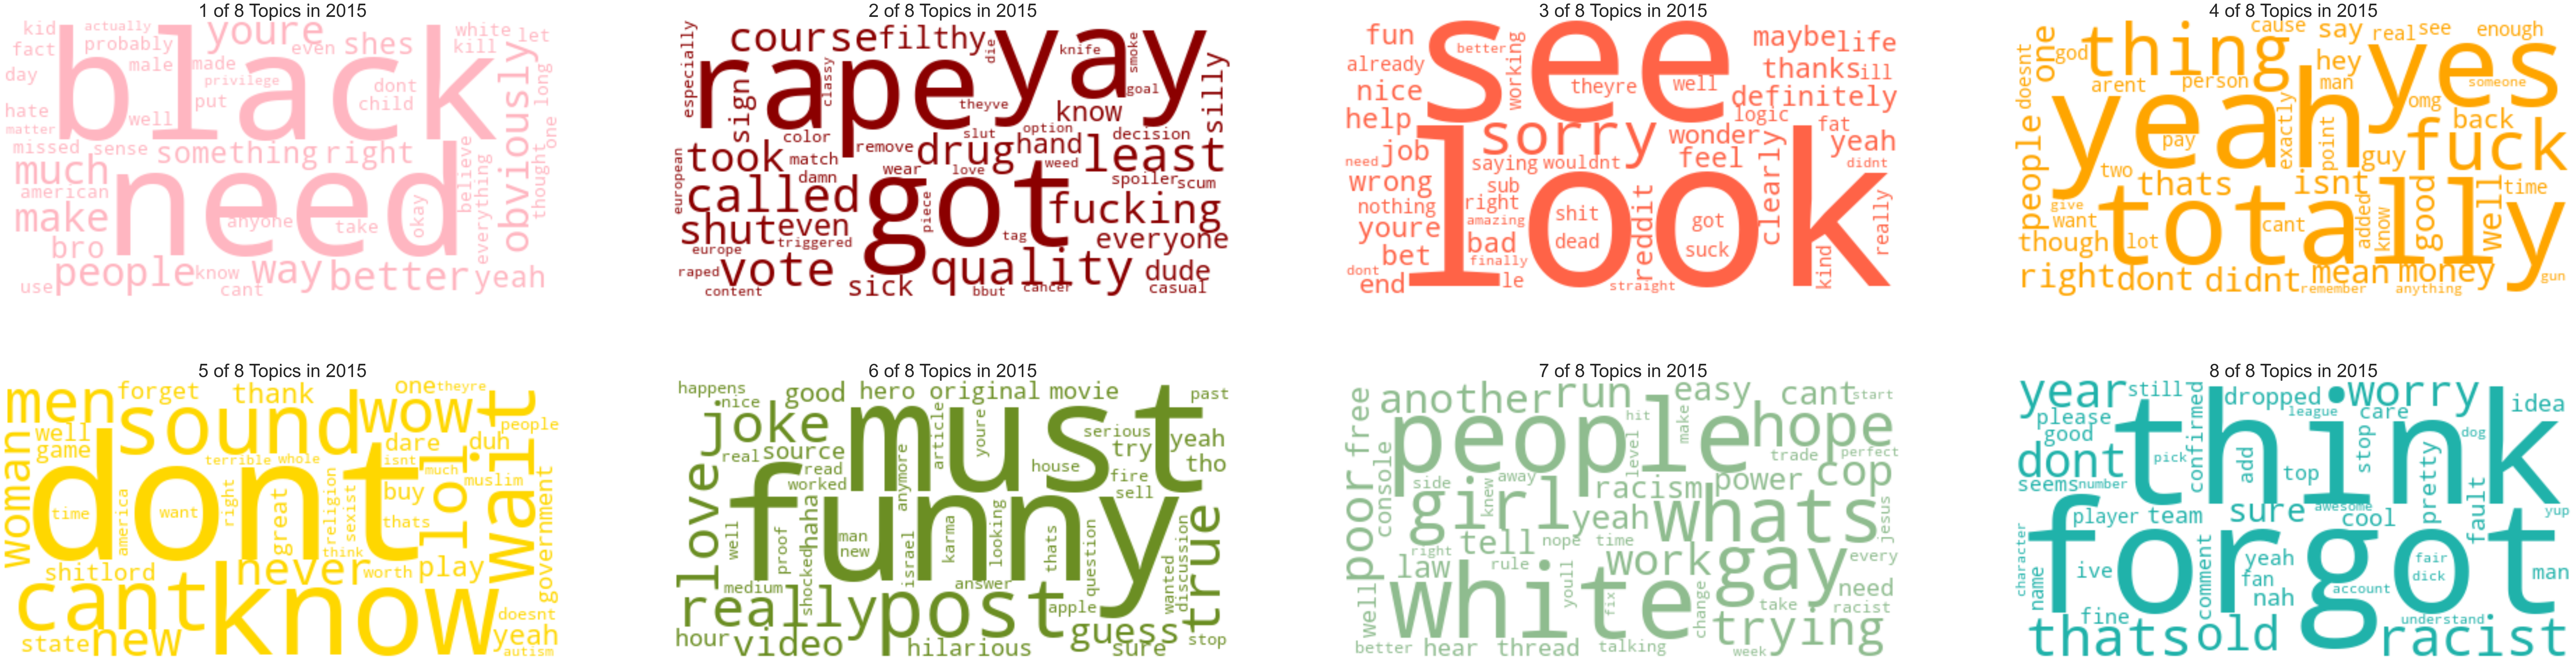

In [13]:
from wordcloud import WordCloud

topic_colors = ['lightpink', 'darkred', 'tomato', 'orange', 'gold', 'olivedrab', 'darkseagreen', 'lightseagreen', 'lightskyblue', 'steelblue']

topic_wordclouds = []

for i in range(num_topics):
    imp_words_topic=""
    comp=lda_model.components_[i]
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:50]
    for word in sorted_words:
      imp_words_topic=imp_words_topic+" "+word[0]
    
    # Generate word cloud with the topic's color
    wordcloud = WordCloud(width=400, height=200, background_color='white', color_func=lambda *args, **kwargs: topic_colors[i]).generate(imp_words_topic)
    topic_wordclouds.append(wordcloud)

plt.figure(figsize=(100, 40))
for i, wordcloud in enumerate(topic_wordclouds):
    plt.subplot(3, 4, i+1) 
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('{} of 8 Topics in 2015'.format(i+1),fontsize=40)
    plt.axis("off")

plt.show()